## Instalando as bibliotecas

In [1]:
%pip install numpy matplotlib scikit-image opencv-python qrcode

Note: you may need to restart the kernel to use updated packages.


## Importando bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform, morphology
from scipy import ndimage
from PIL import Image # Apenas para gerar fundo
import cv2 # Apenas para salvar imagens
import os
import math
import qrcode # Gerar dataset
import random
from scipy.ndimage import binary_hit_or_miss
from skimage import io, color, filters, measure, morphology

### Funções de Rotação e Translação

In [3]:
# Funções para realizar a rotação
def bilinear_interpolate(img, x, y):
    altura, largura = img.shape[:2]
    x0 = int(np.floor(x))
    x1 = min(x0 + 1, largura - 1)
    y0 = int(np.floor(y))
    y1 = min(y0 + 1, altura - 1)

    Ia = img[y0, x0]
    Ib = img[y0, x1]
    Ic = img[y1, x0]
    Id = img[y1, x1]

    wa = (x1 - x) * (y1 - y)
    wb = (x - x0) * (y1 - y)
    wc = (x1 - x) * (y - y0)
    wd = (x - x0) * (y - y0)

    return wa*Ia + wb*Ib + wc*Ic + wd*Id

def rotate_matrix(theta):
    theta = np.deg2rad(theta)
    c =  math.cos(theta)
    s = math.sin(theta)
    matriz = np.array([
        [c, -s, 0],
        [s, c, 0],
        [0, 0, 1]
    ], dtype=float)
    return matriz

def rotacao(img, theta, cval=255):
    altura, largura = img.shape[:2]

    saida = np.ones_like(img) * cval # Imagem com a cor de fundo branco

    cx, cy = largura / 2, altura / 2

    Matriz = rotate_matrix(theta)

    M_inv = np.linalg.inv(Matriz)

    for y_nova in range(altura):
        for x_nova in range(largura):

            xy_saida = np.array([x_nova - cx, y_nova - cy, 1]) # Colocando a origem para o centro da imagem

            xy_entrada = M_inv @ xy_saida # Aplicando a matriz inversa na imagem de saída

            x_entrada, y_entrada = xy_entrada[0] + cx, xy_entrada[1] + cy # Voltando a origem para o canto superior esquerdo

            if 0 <= x_entrada < (largura - 1) and 0 <= y_entrada < (altura - 1):
                saida[y_nova,x_nova] = bilinear_interpolate(img, x_entrada, y_entrada)
    return saida.astype(img.dtype)

def translate_image(img, canvas_size, dx, dy, fill=(255, 255, 255)):
    canvas = Image.new("RGBA", canvas_size, fill + (255,))
    canvas.paste(img, (dx, dy), img if img.mode == 'RGBA' else None)
    return canvas

## Gerador de Dataset

### Funções auxiliares

In [4]:
from scipy import ndimage
def generate_qrcode(data, angle=0, size=1, dx=0, dy=0, canvas_size=(1400, 1400)):
    qr = qrcode.QRCode(
        version=size,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )
    qr.add_data(data)
    qr.make(fit=True)

    img = qr.make_image(fill_color="black", back_color="white").convert('RGB')
    if dx or dy:
        img = translate_image(img, canvas_size, dx, dy)
    img = np.array(img)
    if angle:
        img = ndimage.rotate(img, angle, cval=255, reshape=False) # Usado apenas para a geração de imagens ser mais rápida
        # img = rotacao(img, angle)

    return img


def generate_dataset(directory, quantity, canvas_size):
    for i in range(quantity):
        random_angle = random.randint(0, 360)
        random_size = random.randint(1, 5)
        dx, dy = random.randint(1, 500), random.randint(1, 500)
        data = random.randint(1000, 99999999)
        filename = f"{data}.png"
        path = os.path.join(directory, filename)

        qr = generate_qrcode(data, random_angle, random_size, dx, dy, canvas_size)
        io.imsave(path, qr)

### Gerar Dataset

In [38]:
DATASET_PATH = 'dataset2' # Pasta em que vai ser gerada as imagens
CANVAS_SIZE = (1000, 1000) # Tamanho da imagem fundo da imagem
IMG_QTD = 1 # Quandidade de imagens geradas

# generate_dataset(DATASET_PATH, IMG_QTD, CANVAS_SIZE)

KeyboardInterrupt: 

## Carregando a imagem

In [5]:
DATASET_DIRECTORY = 'dataset2'
IMAGE_NAME = '34268756.png'

image_path = os.path.join(DATASET_DIRECTORY, IMAGE_NAME)

image = io.imread(image_path)

if image.shape[-1] == 4:
    image = image[:,:,:3] # Removendo o canal alpha

image_gray = color.rgb2gray(image)
image_numpy = np.array(image_gray)


### Localizando o local do QR Code na imagem

#### Funções auxiliares

In [7]:
def encontrar_bbox(img_numpy, tollerance=5):

    linhas, colunas = np.where(img_numpy == 0)  # Pega as coordenadas dos pixels pretos

    if len(linhas) == 0 or len(colunas) == 0:
        return None

    # Determina os extremos da bounding box
    y_min, y_max = linhas.min(), linhas.max()
    x_min, x_max = colunas.min(), colunas.max()

    # Adicionando tolerância
    y_min, y_max = y_min - tollerance, y_max + tollerance
    x_min, x_max = x_min - tollerance, x_max + tollerance

    return x_min, y_min, x_max, y_max

def show_qrcode_detected(bbox, img):
    x_min, y_min, x_max, y_max = bbox
    return img[y_min:y_max, x_min:x_max]




#### Recortando o qr code na imagem

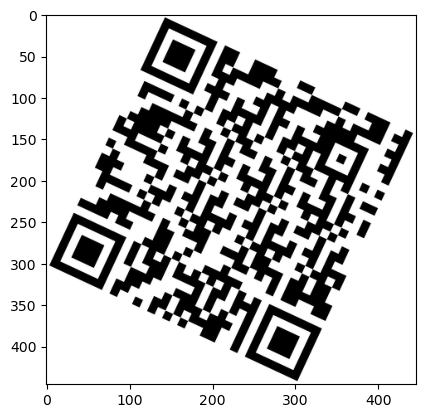

In [10]:
bbox = encontrar_bbox(image_numpy)

bbox_image = show_qrcode_detected(bbox, image_numpy)

plt.imshow(bbox_image, cmap='gray')
plt.show()
plt.imsave('qrcode_detected.png', bbox_image, cmap='gray')

### Função implementação canny

In [11]:
def gaussian_blur(image, sigma=1):
    return ndimage.gaussian_filter(image, sigma)

def sobel_filters(image):
    Kx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    Ix = ndimage.convolve(image, Kx)
    Iy = ndimage.convolve(image, Ky)

    G = np.hypot(Ix, Iy)  # magnitude
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)  # direção do gradiente

    return G, theta

def non_max_suppression(G, theta):
    M, N = G.shape
    Z = np.zeros((M, N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 255
                r = 255

                # 0 graus
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = G[i, j+1]
                    r = G[i, j-1]
                # 45 graus
                elif (22.5 <= angle[i,j] < 67.5):
                    q = G[i+1, j-1]
                    r = G[i-1, j+1]
                # 90 graus
                elif (67.5 <= angle[i,j] < 112.5):
                    q = G[i+1, j]
                    r = G[i-1, j]
                # 135 graus
                elif (112.5 <= angle[i,j] < 157.5):
                    q = G[i-1, j-1]
                    r = G[i+1, j+1]

                if (G[i,j] >= q) and (G[i,j] >= r):
                    Z[i,j] = G[i,j]
                else:
                    Z[i,j] = 0
            except IndexError as e:
                pass
    return Z

def threshold(image, lowThresholdRatio=0.05, highThresholdRatio=0.15):
    highThreshold = image.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio

    M, N = image.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(25)
    strong = np.int32(255)

    strong_i, strong_j = np.where(image >= highThreshold)
    weak_i, weak_j = np.where((image <= highThreshold) & (image >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res, weak, strong

def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if img[i,j] == weak:
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i,j] = strong
                else:
                    img[i,j] = 0
    return img

def canny(image, sigma=1, low_threshold=0.05, high_threshold=0.15):
    blurred = gaussian_blur(image, sigma)
    gradient_magnitude, gradient_direction = sobel_filters(blurred)
    suppressed = non_max_suppression(gradient_magnitude, gradient_direction)
    thresholded, weak, strong = threshold(suppressed, low_threshold, high_threshold)
    final = hysteresis(thresholded, weak, strong)
    return final

def apply_canny(image, sigma=1, low_threshold=0.05, high_threshold=0.15):
    # Converte a imagem para escala de cinza se necessário
    if len(image.shape) == 3:
        image = color.rgb2gray(image)

    # Aplica o filtro Canny
    edges = canny(image, sigma, low_threshold, high_threshold)

    tested_angles = np.linspace(-np.pi / 4, np.pi / 4, 100)

    # Aplica a transformada de Hough para detectar linhas
    h, theta, d = transform.hough_line(edges, theta=tested_angles)

    # Seleciona os picos das linhas detectadas
    accums, angles, dists = transform.hough_line_peaks(h, theta, d)

    if len(angles) == 0:
        print("Nenhuma linha detectada. A rotação não pôde ser estimada.")
        rotation_angle = 0
    else:
        # Estima o ângulo de rotação usando a mediana dos ângulos detectados
        rotation_angle = np.median(angles)

    # Converte o ângulo para graus (para visualização e correção)
    angle_deg = np.degrees(rotation_angle)
    print("Ângulo detectado (em graus):", angle_deg)

    # Corrige a rotação
    corrected_image = rotacao(image, -angle_deg, cval=1.0)
    return corrected_image



### Ajuste do ângulo da imagem

Ângulo detectado (em graus): 24.999999999999996


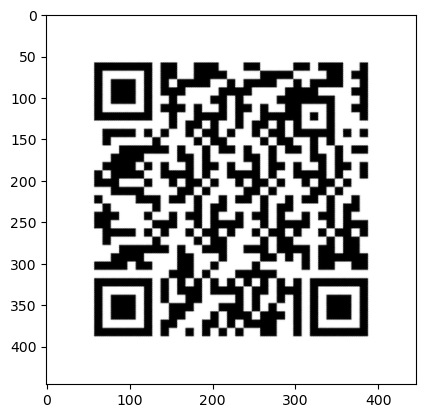

In [17]:

corrected_image = apply_canny(bbox_image, sigma=2)

plt.imshow(corrected_image, cmap='gray')
plt.imsave('output_canny.png', corrected_image, cmap='gray')

### Recortando novamente a imagem para remover o fundo

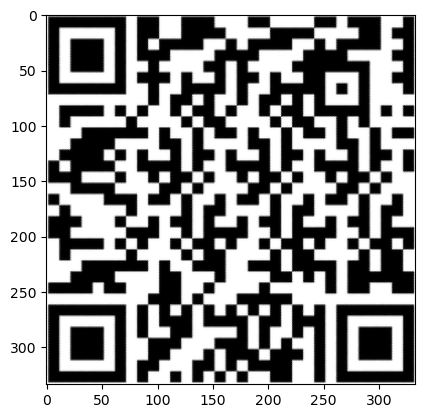

In [19]:
# Realizando o recorte da imagem novamente para ficar centralizada
img_recortada_final = show_qrcode_detected(encontrar_bbox(corrected_image), corrected_image)

plt.imshow(img_recortada_final, cmap='gray')
plt.imsave('output_canny_recortada.png', img_recortada_final, cmap='gray')

### Realizando a rotação para ajustar os quadrados do QR Code (Funciona alguma vezes - procurar outra forma)

#### Funções auxiliares

In [13]:
# Divide a imagem em 4 quadrantes e conta a quantidade de pixeis pretos
def detectar_quadrados_posicionais(img):
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    h, w = img.shape
    metade_h, metade_w = h // 2, w // 2

    quadrantes = {
        "superior_esquerdo": img[0:metade_h, 0:metade_w],
        "superior_direito": img[0:metade_h, metade_w:w],
        "inferior_esquerdo": img[metade_h:h, 0:metade_w],
        "inferior_direito": img[metade_h:h, metade_w:w]
    }

    contagem_pretos = {k: np.sum(v < 128) for k, v in quadrantes.items()}

    return contagem_pretos

# Verifica com base nos quadrantes com mais pixeis para definir a rotação de ajuste
def estimar_rotacao_base_quadrantes(contagem):
    # Ordena pela quantidade de pixels pretos (decrescente)
    mais_escuros = sorted(contagem.items(), key=lambda item: item[1], reverse=True)

    nomes = [q[0] for q in mais_escuros[:3]]


    if set(nomes) == {"superior_esquerdo", "superior_direito", "inferior_esquerdo"}:
        if "superior_esquerdo" in nomes and nomes[0] == "superior_esquerdo":
            return 0
    elif set(nomes) == {"inferior_esquerdo", "inferior_direito", "superior_esquerdo"}:
        return 90
    elif set(nomes) == {"inferior_esquerdo", "inferior_direito", "superior_direito"}:
        return 180
    elif set(nomes) == {"superior_direito", "superior_esquerdo", "inferior_direito"}:
        return 270

    return 0

#### Aplicando a rotação

superior_esquerdo: 14093 pixels pretos
superior_direito: 13401 pixels pretos
inferior_esquerdo: 13342 pixels pretos
inferior_direito: 14359 pixels pretos
Rotação necessária: 270°


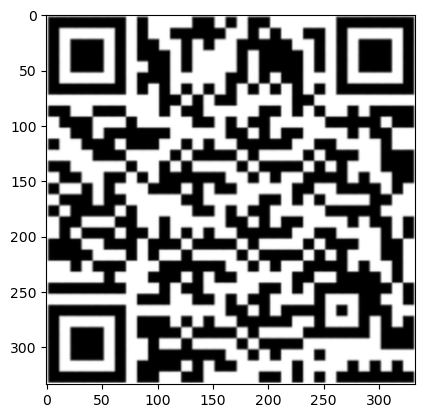

In [18]:
corrected_image_array = np.array(corrected_image)

contagem = detectar_quadrados_posicionais(corrected_image_array)

for k, v in contagem.items():
    print(f"{k}: {v} pixels pretos")

angulo = estimar_rotacao_base_quadrantes(contagem)

print(f"Rotação necessária: {angulo}°")



# Rotacionando para a orientação correta do qr code
imagem_rotacionada_final = rotacao(img_recortada_final, -angulo, cval=1.0)

plt.imshow(imagem_rotacionada_final, cmap='gray')
plt.imsave('output_final.png', imagem_rotacionada_final, cmap='gray')


### Exibindo os resultados

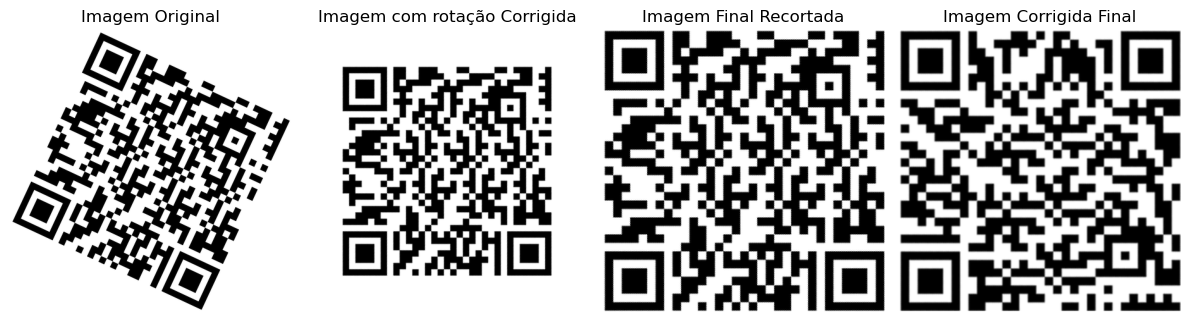

True

In [15]:
# Exibe a imagem original, a imagem com a correção de rotação e a imagem final recortada
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
axes[0].imshow(bbox_image, cmap='gray')
axes[0].set_title('Imagem Original')
axes[0].axis('off')

axes[1].imshow(corrected_image, cmap='gray')
axes[1].set_title('Imagem com rotação Corrigida')
axes[1].axis('off')

axes[2].imshow(img_recortada_final, cmap='gray')
axes[2].set_title('Imagem Final Recortada')
axes[2].axis('off')

axes[3].imshow(imagem_rotacionada_final, cmap='gray')
axes[3].set_title('Imagem Corrigida Final')
axes[3].axis('off')

plt.tight_layout()
plt.show()

corrected_image_uint8 = (imagem_rotacionada_final * 255).astype(np.uint8)

cv2.imwrite('qrcode_detected_rotated.png',corrected_image_uint8)

In [104]:
# 1. Carregar e converter para binário
imagem_bin = corrected_image_uint8 > 0.5  # Converter para binário (ajuste o limiar conforme necessário)

# 2. Criar um kernel para a borda de um quadrado de 120x120 pixels
for i in range(1, 150):
    tam_quadrado = i
    kernel1 = np.ones((tam_quadrado, tam_quadrado), dtype=np.uint8)  # Fundo branco (1)
    kernel1[0, :] = 0   # Linha superior preta (borda)
    kernel1[-1, :] = 0  # Linha inferior preta (borda)
    kernel1[:, 0] = 0   # Coluna esquerda preta (borda)
    kernel1[:, -1] = 0  # Coluna direita preta (borda)


    # 3. Aplicar Hit-or-Miss
    hit = erosion(imagem_bin, kernel)

    miss = erosion(~imagem_bin, kernel)

    # 5. Fazer a interseção para obter o Hit-or-Miss
    resultado = hit & miss

    # 4. Exibir resultados
    # fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # axs[0].imshow(imagem_bin, cmap="gray")
    # axs[0].set_title("Imagem Binária")


    # axs[1].imshow(resultado, cmap="gray")
    # axs[1].set_title("Resultado Hit-or-Miss (Borda do Quadrado)")

    # plt.show()
    nao_pretos = resultado != 0  # True para pixels não pretos, False para preto

    # 3. Contar os pixels não pretos
    quantidade_nao_pretos = np.sum(nao_pretos)

    # 4. Exibir o resultado
    print(f"Quantidade de pixels não pretos: {quantidade_nao_pretos}")




Quantidade de pixels não pretos: 0
Quantidade de pixels não pretos: 0
Quantidade de pixels não pretos: 0
Quantidade de pixels não pretos: 0
Quantidade de pixels não pretos: 0
Quantidade de pixels não pretos: 0
Quantidade de pixels não pretos: 0
Quantidade de pixels não pretos: 0


KeyboardInterrupt: 

C:\Users\newto\AppData\Local\Temp\ipykernel_4444\1472259481.py:11: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  imagem_erodida = morphology.erosion(imagem_bin, morphology.square(3))


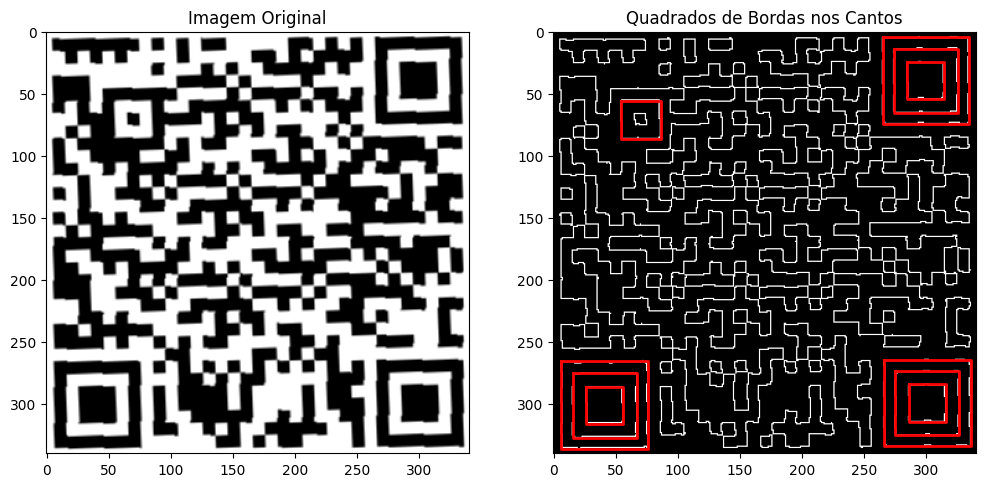

In [118]:


# 1. Carregar a imagem
# imagem = corrected_image_uint8



# 2. Binarizar a imagem (threshold de Otsu)
limiar = filters.threshold_otsu(corrected_image_uint8)
imagem_bin = corrected_image_uint8 < limiar  # Preto vira 1, branco vira 0

# 3. Destacar apenas a borda (subtraindo a versão erodida da original)
imagem_erodida = morphology.erosion(imagem_bin, morphology.square(3))
bordas = imagem_bin & ~imagem_erodida

# 4. Detectar componentes conectados manualmente via flood-fill
visitado = np.zeros_like(bordas, dtype=bool)
quadrados_nos_cantos = []

def flood_fill(img, x, y):
    """Realiza flood-fill para marcar a região conectada a (x, y)
    e retorna o bounding box (min_x, min_y, max_x, max_y) e a área (número de pixels)"""
    stack = [(x, y)]
    min_x, min_y, max_x, max_y = x, y, x, y
    
    while stack:
        px, py = stack.pop()
        if not visitado[px, py] and img[px, py]:
            visitado[px, py] = True
            min_x, max_x = min(min_x, px), max(max_x, px)
            min_y, max_y = min(min_y, py), max(max_y, py)
            # Considera os 4 vizinhos (conexão 4)
            if px > 0: stack.append((px - 1, py))
            if px < img.shape[0] - 1: stack.append((px + 1, py))
            if py > 0: stack.append((px, py - 1))
            if py < img.shape[1] - 1: stack.append((px, py + 1))
    
    return min_x, min_y, max_x, max_y

# 5. Percorrer a imagem e identificar os quadrados (regiões conectadas)
for i in range(bordas.shape[0]):
    for j in range(bordas.shape[1]):
        if bordas[i, j] and not visitado[i, j]:
            min_x, min_y, max_x, max_y = flood_fill(bordas, i, j)
            # Calcular altura e largura do bounding box
            altura = max_x - min_x
            largura = max_y - min_y
            # Filtrar: região aproximadamente quadrada e não muito pequena
            if 0.8 < (altura / largura) < 1.2 and altura > 10 and largura > 10:
                # Verificar se o bounding box está exatamente nos cantos da imagem
                h, w = bordas.shape
                # Tolerância de 50 pixels para considerar o quadrado "no canto"
                if (min_x < 75 and min_y < 75) or \
                   (min_x < 75 and max_y > w - 75) or \
                   (max_x > h - 75 and min_y < 75) or \
                   (max_x > h - 75 and max_y > w - 75):
                    quadrados_nos_cantos.append((min_x, min_y, max_x, max_y))

# 6. Exibir os resultados
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(corrected_image_uint8, cmap="gray")
ax[0].set_title("Imagem Original")

ax[1].imshow(bordas, cmap="gray")
for (min_x, min_y, max_x, max_y) in quadrados_nos_cantos:
    ax[1].plot([min_y, max_y, max_y, min_y, min_y],
               [min_x, min_x, max_x, max_x, min_x],
               '-r', linewidth=2)
ax[1].set_title("Quadrados de Bordas nos Cantos")
plt.show()

